# Introduction

This notebook conducts a **fairness analysis** on a machine learning model trained to predict mental health treatment needs based on survey data. The model aims to classify whether individuals are likely to seek or receive treatment (treatment as the target). Fairness evaluation is performed across key sensitive attributes, including **Gender, Age Group and Country** to ensure equitable prediction outcomes across diverse groups. The analysis at the end identifies potential biases in model predictions and highlights groups that may be at risk of under- or over-prediction.

This notebook conducts a fairness analysis on a machine learning model trained to predict mental health treatment needs (treatment) based on survey data.
We evaluated the model's fairness across key sensitive attributes — **Gender, Age Group and Country** — using metrics such as **Selection Rate, Disparate Impact (DI), Equalized Odds Difference (EOD), and True Positive Rate (TPR)**.


## Model and Data Preparation Section

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/survey.csv'
df = pd.read_csv(path, encoding='latin1')

df = df.drop(columns=['comments', 'Timestamp', 'state', 'no_employees', 'anonymity'])
df = df[(df['Age'] >= 18) & (df['Age'] <= 100)]
df['self_employed'] = df['self_employed'].fillna('No')
df.drop_duplicates()
df['work_interfere'] = df['work_interfere'].fillna('Not applicable')

#Function to clean the gender variable into 'female', 'male', and 'other'
def clean_gender(gender):
    gender = str(gender).strip().lower()
    if gender in ['male', 'm', 'cis male', 'male (cis)', 'man', 'mail', 'cis man', 'malr', 'make', 'maile']:
        return 'Male'
    elif gender in ['female', 'f', 'cis female', 'woman', 'female (cis)', 'cis-female/femme', 'femake', 'femail', 'female ', 'trans female']:
        return 'Female'
    else:
        return 'Other'

# Apply the cleaning function
df['Gender'] = df['Gender'].apply(clean_gender)

for col in ['Gender','Country','self_employed','family_history','work_interfere','remote_work','tech_company','benefits','care_options',
            'wellness_program','seek_help','leave','mental_health_consequence','phys_health_consequence','coworkers','supervisor',
            'mental_health_interview','phys_health_interview','mental_vs_physical','obs_consequence']:
            vc = df[col].value_counts(normalize=True)
            rare = vc[vc < 0.01]

vc = df['Country'].value_counts(normalize=True)
rare = vc[vc < 0.01]
rare_labels = rare.index.tolist()
df['Country_grouped'] = df['Country'].replace(rare_labels, 'Other')

!pip install matplotlib-venn

# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

!pip install cartopy
import cartopy

!apt-get update -qq
!apt-get install -y libarchive-dev

!pip install libarchive-c

# Test
import libarchive
print("Import succeeded:", libarchive)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.semi_supervised import SelfTrainingClassifier, LabelPropagation
from sklearn.metrics import classification_report, roc_auc_score

# 1. Load and preprocess data
df['treatment'] = df['treatment'].map({'Yes': 1, 'No': 0})

# 2. Define features and target
cat_cols = [
    'Gender', 'Country_grouped', 'self_employed', 'family_history',
    'work_interfere', 'remote_work', 'tech_company', 'benefits',
    'care_options', 'wellness_program', 'seek_help', 'leave',
    'mental_health_consequence', 'phys_health_consequence',
    'coworkers', 'supervisor', 'mental_health_interview',
    'phys_health_interview', 'mental_vs_physical', 'obs_consequence'
]
num_cols = ['Age']
target = 'treatment'

X = df[cat_cols + num_cols]
y = df[target]

Mounted at /content/drive
Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 126333 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1.4_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1.4) ...
Setting up libarchive-dev:amd64 (3.6.0-1ubuntu1.4) ...
Processing triggers for man-db (2.10.2-1) ...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.3 MB/s eta 0:00:00
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31629 sha256=002a6e93dd99b8eeffc7fc6b1ed7f9a85682f4b206c00af520d632bf1efe6e57
  Stored in directory: /root/.cache/pip/wheels/32/98/bd/4893d6923dd027f455b250367d402bfd69a6f4416581df46db
Successfully built libarchive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 64.9 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy 

Import succeeded: <module 'libarchive' from '/usr/local/lib/python3.11/dist-packages/libarchive/__init__.py'>


In [ ]:
# 3. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import classification_report

In [ ]:
def apply_pseudo_labeling(base_model, X_labeled, y_labeled, X_unlabeled, preprocessor=None, threshold=0.9):

    # Fit and transform preprocessing if provided
    if preprocessor is not None:
        preprocessor.fit(X_labeled)
        X_labeled_encoded = preprocessor.transform(X_labeled)
        X_unlabeled_encoded = preprocessor.transform(X_unlabeled)
    else:
        X_labeled_encoded = X_labeled
        X_unlabeled_encoded = X_unlabeled

    # Train the base model
    base_model.fit(X_labeled_encoded, y_labeled)

    # Predict pseudo-labels for unlabeled data
    proba_unlabeled = base_model.predict_proba(X_unlabeled_encoded)
    preds_unlabeled = np.argmax(proba_unlabeled, axis=1)
    max_proba = np.max(proba_unlabeled, axis=1)

    # Select high-confidence pseudo-labeled samples
    mask = max_proba >= threshold
    X_pseudo = X_unlabeled.iloc[mask]
    y_pseudo = preds_unlabeled[mask]

    # Combine original labeled data with pseudo-labeled data
    X_augmented = pd.concat([X_labeled, X_pseudo], axis=0)
    y_augmented = pd.concat([y_labeled, pd.Series(y_pseudo, index=X_pseudo.index)], axis=0)

    return X_augmented, y_augmented

In [ ]:
# Fill missing values for categorical columns
X[cat_cols] = X[cat_cols].fillna('Missing').astype(str)

# Preprocessor for LR, RF, XGB
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(
    [('onehot', ohe, cat_cols)],
    remainder='passthrough'
)

# Base models
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Pipelines for models needing preprocessing

xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', xgb)
])

<ipython-input-5-41be26e93de1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].fillna('Missing').astype(str)


In [ ]:
# Further split X_train_base into Labeled and Unlabeled simulation
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2, random_state=42
)

In [ ]:
print("===== PSEUDO-LABELING =====")

# XGBoost (Pseudo-Labeling)
X_aug_xgb, y_aug_xgb = apply_pseudo_labeling(xgb, X_labeled, y_labeled, X_unlabeled, preprocessor=preprocessor, threshold=0.95)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_aug_xgb, y_aug_xgb, stratify=y_aug_xgb, test_size=0.2, random_state=42)
xgb_pipeline.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xgb_pipeline.predict(X_test_xgb)
print("Pseudo-Labeling XGBoost:\n", classification_report(y_test_xgb, y_pred_xgb))

===== PSEUDO-LABELING =====


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:39:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pseudo-Labeling XGBoost:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89        93
           1       0.88      0.90      0.89        91

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:39:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import joblib
import os
import json

print("===== FINE-TUNING PSEUDO-LABELING XGBOOST (Small LR + More Trees) =====")

# 1. Pseudo-labeling
X_aug_xgb, y_aug_xgb = apply_pseudo_labeling(xgb, X_labeled, y_labeled, X_unlabeled, preprocessor=preprocessor, threshold=0.95)

# 2. Train-test split
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_aug_xgb, y_aug_xgb, stratify=y_aug_xgb, test_size=0.2, random_state=42
)

# 3. Column types
categorical_cols = X_train_xgb.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train_xgb.select_dtypes(exclude=['object']).columns.tolist()

# 4. Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

# 5. Pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# 6. New hyperparameter search space
param_dist = {
    'classifier__n_estimators': [300, 400, 500, 600, 800],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__learning_rate': [0.01, 0.03, 0.05, 0.07],
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.05, 0.1],
    'classifier__reg_alpha': [0, 0.01, 0.1],
    'classifier__reg_lambda': [1, 1.5, 2.0]
}

# 7. RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 8. Fit
random_search.fit(X_train_xgb, y_train_xgb)

# 9. Predict
best_xgb_pipeline = random_search.best_estimator_
y_pred_xgb = best_xgb_pipeline.predict(X_test_xgb)

# 10. Report
print("\n===== Best Parameters =====")
print(random_search.best_params_)

print("\n===== Best Cross-Validation Accuracy =====")
print(random_search.best_score_)

print("\n===== Test Set Classification Report =====")
print(classification_report(y_test_xgb, y_pred_xgb))

# 11. Save model and best params
save_dir = "/content/models"
os.makedirs(save_dir, exist_ok=True)

joblib.dump(best_xgb_pipeline, os.path.join(save_dir, "best_xgb_pipeline_v2.pkl"))
print(f"Model saved to {save_dir}/best_xgb_pipeline_v2.pkl")

with open(os.path.join(save_dir, "best_xgb_params_v2.json"), "w") as f:
    json.dump(random_search.best_params_, f, indent=4)
print(f"Best parameters saved to {save_dir}/best_xgb_params_v2.json")

===== FINE-TUNING PSEUDO-LABELING XGBOOST (Small LR + More Trees) =====


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:39:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 50 candidates, totalling 250 fits

===== Best Parameters =====
{'classifier__subsample': 0.8, 'classifier__reg_lambda': 2.0, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 300, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.03, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.7}

===== Best Cross-Validation Accuracy =====
0.840089460441711

===== Test Set Classification Report =====
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        93
           1       0.88      0.92      0.90        91

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

Model saved to /content/models/best_xgb_pipeline_v2.pkl
Best parameters saved to /content/models/best_xgb_params_v2.json


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:40:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Fariness Analysis Section

### **Sensitive Feature Extraction**

In fairness evaluation, sensitive features are chosen based on their relevance to societal bias, historical disparities, and the potential for unequal treatment outcomes.  
For this mental health treatment prediction task, we selected **Gender, Age Group, and Country** as sensitive features because they are closely linked to historical disparities in mental health access and diagnosis, and may influence the likelihood of being identified for treatment.

In [ ]:
# === 1. Process Age: Binning into age_group ===
import pandas as pd

# Assume your X_test already contains a column named "Age"
# Define binning rules, for example: 18-25, 26-35, 36-45, 45+
bins = [0, 25, 35, 45, 100]
labels = ['18-25', '26-35', '36-45', '45+']
X_test["age_group"] = pd.cut(X_test["Age"], bins=bins, labels=labels, right=False)

# === 2. Process Gender: Cleaning and standardization ===

# Standardize the "Gender" field into 'male' / 'female' / 'other'
def clean_gender(gender):
    if pd.isnull(gender):
        return "Unknown"
    gender = gender.strip().lower()
    if gender in ["male", "m", "man", "cis male", "cis man"]:
        return "male"
    elif gender in ["female", "f", "woman", "cis female", "cis woman"]:
        return "female"
    else:
        return "other"

X_test["gender_clean"] = X_test["Gender"].apply(clean_gender)

# (Optional) You may merge "other" and "Unknown" into a single group
# depending on the sample size of each group

# === 3. Create the sensitive_features dataframe ===
sensitive_features = X_test[["gender_clean", "age_group"]].copy()
sensitive_features.columns = ["gender", "age_group"]  # Rename for consistency

In [ ]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.8 MB/s eta 0:00:00


### Accuracy and Selection Rate

In [ ]:
# === Import necessary packages for fairness analysis ===
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_ratio, equalized_odds_difference
from sklearn.metrics import accuracy_score as sk_accuracy_score

# Make predictions
y_pred_xgb = best_xgb_pipeline.predict(X_test)

# Fairness analysis by Gender
print("=== Gender Fairness Analysis ===")
gender_metric = MetricFrame(
    metrics={"accuracy": sk_accuracy_score, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred_xgb,
    sensitive_features=sensitive_features["gender"]
)
print(gender_metric.by_group)

# Fairness analysis by Age Group
print("\n=== Age Group Fairness Analysis ===")
age_metric = MetricFrame(
    metrics={"accuracy": sk_accuracy_score, "selection_rate": selection_rate},
    y_true=y_test,
    y_pred=y_pred_xgb,
    sensitive_features=sensitive_features["age_group"]
)
print(age_metric.by_group)

=== Gender Fairness Analysis ===
        accuracy  selection_rate
gender                          
female  0.916667        0.770833
male    0.801980        0.490099
other   1.000000        1.000000

=== Age Group Fairness Analysis ===
           accuracy  selection_rate
age_group                          
18-25      0.806452        0.419355
26-35      0.857143        0.514286
36-45      0.761905        0.666667
45+        0.823529        0.588235


In [ ]:
# === 1. Import necessary packages ===
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score as sk_accuracy_score

# === 2. Make prediction ===
y_pred_xgb = best_xgb_pipeline.predict(X_test)

# === 3. Map logical feature name to real column name ===
feature_mapping = {
    "Gender": "gender_clean",
    "Age Group": "age_group",
    "Country": "Country_grouped",
}

# === 4. For each sensitive feature, do fairness analysis and print table ===
for logical_name, real_column in feature_mapping.items():
    print(f"\n=== Fairness Analysis by {logical_name} ===")

    # Create MetricFrame for fairness metrics
    metric = MetricFrame(
        metrics={"accuracy": sk_accuracy_score, "selection_rate": selection_rate},
        y_true=y_test,
        y_pred=y_pred_xgb,
        sensitive_features=X_test[real_column]
    )

    # Calculate sample size per group
    sample_counts = X_test[real_column].value_counts().to_dict()

    # Print nicely
    result_df = metric.by_group.copy()
    result_df["n_samples"] = result_df.index.map(lambda x: sample_counts.get(x, 0))

    # Reorder columns
    result_df = result_df[["n_samples", "accuracy", "selection_rate"]]

    print(result_df)

    # Warning for small groups
    for group, n in sample_counts.items():
        if n < 10:
            print(f"\nWarning: '{group}' has only {n} samples. Interpret fairness metrics with caution.")


=== Fairness Analysis by Gender ===
              n_samples  accuracy  selection_rate
gender_clean                                     
female               48  0.916667        0.770833
male                202  0.801980        0.490099
other                 1  1.000000        1.000000


=== Fairness Analysis by Age Group ===
           n_samples  accuracy  selection_rate
age_group                                     
18-25             31  0.806452        0.419355
26-35            140  0.857143        0.514286
36-45             63  0.761905        0.666667
45+               17  0.823529        0.588235

=== Fairness Analysis by Country ===
                 n_samples  accuracy  selection_rate
Country_grouped                                     
Australia                4  1.000000        0.750000
Canada                  15  0.733333        0.466667
Germany                  7  0.714286        0.571429
Ireland                  5  1.000000        0.400000
Netherlands              9  0.5555

## **Fairness Analysis (Accuracy and Selection Rate)**
This fairness analysis evaluates the model’s prediction performance across different sensitive groups, based on the mental health treatment survey dataset. The objective is to identify potential biases or disparities in prediction outcomes across demographic and employment-related features.

The analysis focuses on three main dimensions: **Gender**, **Age Group**, and **Country**.


## **1. Gender Fairness**

| Gender | n_samples | Accuracy | Selection Rate |
|:---|:---|:---|:---|
| Female | 48 | 91.7% | 77.1% |
| Male | 202 | 80.2% | 49.1% |
| Other | 1 | 100.0% | 100.0% |

**Findings**:
- The model predicts treatment needs for **female** respondents with significantly higher accuracy (91.7%) compared to **male** respondents (80.2%).
- **Female** respondents are more likely to be predicted as needing treatment, with a selection rate of 77.1% versus 49.1% for males.
- The "other" gender group contains only **one** sample, and therefore results for this group are not statistically reliable.

**Insight**:
- There is a noticeable **underprediction risk for male respondents**, suggesting the model may be less sensitive to treatment needs among males.
- Future improvement efforts could focus on boosting recall or balancing sensitivity across genders.

## **2. Age Group Fairness**

| Age Group | n_samples | Accuracy | Selection Rate |
|:---|:---|:---|:---|
| 18–25 | 31 | 80.6% | 41.9% |
| 26–35 | 140 | 85.7% | 51.4% |
| 36–45 | 63 | 76.2% | 66.7% |
| 45+ | 17 | 82.4% | 58.8% |

**Findings**:
- The model performs best for the **26–35** age group, achieving 85.7% accuracy and a moderate selection rate.
- The **36–45** group shows the lowest accuracy (76.2%) despite a relatively high selection rate (66.7%).
- The **18–25** group has a notably low selection rate (41.9%), suggesting a risk of **missing younger individuals** who might need treatment.

**Insight**:
- **Potential underprediction exists among the youngest group (18–25 years old)**, which could lead to untreated mental health issues if not addressed.
- The model could benefit from calibration to ensure fair sensitivity across age groups, especially for younger respondents.

## **3. Country Analysis**

Although country information was available, **the distribution across countries was highly imbalanced**, with the United States and United Kingdom comprising the majority of samples (152 and 38 respectively), while other countries had very small sample sizes (4–9 samples each).

| Country | n_samples |
|:---|:---|
| United States | 152 |
| United Kingdom | 38 |
| Other countries (Australia, Germany, Ireland, Netherlands, etc.) | 4–9 |

### Focused Groups

We focused fairness evaluation on the **United States** and **United Kingdom** groups, where sample sizes are sufficiently large for reliable analysis.  
Minor groups were excluded from primary fairness conclusions due to small sample sizes and statistical instability.


### Results Summary (Major Groups)

| Country Group | n_samples | Accuracy | Selection Rate |
|:---|:---|:---|:---|
| United States | 152 | 0.842 | 0.586 |
| United Kingdom | 38 | 0.816 | 0.447 |

**Findings**

- **Consistency Across Major Groups**:  
  The model maintained relatively stable performance across the United States and United Kingdom groups, with accuracies around 0.82–0.84 and selection rates between 0.45 and 0.59.

- **Selection Rate Difference**:  
  While the United States group exhibited a slightly higher selection rate (0.586) compared to the United Kingdom (0.447), the difference is moderate and within an acceptable range.


**Insights**:  
- Based on available data, no significant country-level bias was detected between the United States and United Kingdom groups.  
- However, ongoing monitoring is recommended, especially as additional data becomes available.

### Caution Regarding Minor Groups

- Other country groups (e.g., Australia, Germany, Ireland, Netherlands) had very limited sample sizes (≤15 samples each).
- As such, fairness metrics for these groups should be interpreted with caution and were not included in the primary fairness evaluation.

### Disparate Impact and Equalized Odds Difference

In [ ]:
# === Only output DI and EOD for each sensitive feature ===
for logical_name, real_column in feature_mapping.items():
    print(f"\n=== Fairness Summary for {logical_name} ===")

    # === Step 1: Subset data if feature is Country ===
    if logical_name == "Country":
        # Only keep samples where country is United States or United Kingdom
        mask = X_test[real_column].isin(["United States", "United Kingdom"])
        y_true_subset = y_test[mask]
        y_pred_subset = y_pred_xgb[mask]
        sensitive_feature_subset = X_test.loc[mask, real_column]
    else:
        # Otherwise use full data
        y_true_subset = y_test
        y_pred_subset = y_pred_xgb
        sensitive_feature_subset = X_test[real_column]

    # === Step 2: Calculate Fairness Metrics ===

    # 1. Disparate Impact
    selection_rates = MetricFrame(
        metrics=selection_rate,
        y_true=y_true_subset,
        y_pred=y_pred_subset,
        sensitive_features=sensitive_feature_subset
    ).by_group
    di = selection_rates.min() / selection_rates.max()

    # 2. Equalized Odds Difference
    eod = equalized_odds_difference(
        y_true=y_true_subset,
        y_pred=y_pred_subset,
        sensitive_features=sensitive_feature_subset
    )

    # Print results
    print(f"Disparate Impact (DI): {di:.3f} (Ideal: 1)")
    print(f"Equalized Odds Difference (EOD): {eod:.3f} (Ideal: 0)")


=== Fairness Summary for Gender ===
Disparate Impact (DI): 0.490 (Ideal: 1)
Equalized Odds Difference (EOD): 0.221 (Ideal: 0)

=== Fairness Summary for Age Group ===
Disparate Impact (DI): 0.629 (Ideal: 1)
Equalized Odds Difference (EOD): 0.385 (Ideal: 0)

=== Fairness Summary for Country ===
Disparate Impact (DI): 0.764 (Ideal: 1)
Equalized Odds Difference (EOD): 0.061 (Ideal: 0)


## **Fairness Analysis (Disparate Impact and Equalized Odds Difference)**

Two key fairness metrics were assessed:
- **Disparate Impact (DI)**: Measures the ratio of positive prediction rates between groups. A value close to 1 indicates fairness.
- **Equalized Odds Difference (EOD)**: Measures the difference in True Positive Rate (TPR) and False Positive Rate (FPR) across groups. A value close to 0 indicates fairness.

### Gender

- **Disparate Impact (DI)**: 0.490 (Ideal: 1)
- **Equalized Odds Difference (EOD)**: 0.221 (Ideal: 0)

**Findings**:
- Male individuals are significantly less likely to be predicted as needing treatment compared to female individuals.
- There is a substantial difference in the True Positive and False Positive Rates between male and female groups.

**Potential Risks**:
- Male individuals may be under-detected by the model, leading to potential delays or omissions in mental health interventions.
- Gender bias could result in unequal access to mental health support.

### Age Group

- **Disparate Impact (DI)**: 0.629 (Ideal: 1)
- **Equalized Odds Difference (EOD)**: 0.385 (Ideal: 0)

**Findings**:
- Younger individuals, particularly the 18–25 age group, show lower positive prediction rates compared to older groups.
- A notable gap exists in TPR and FPR across different age segments.

**Potential Risks**:
- Younger populations may be at a higher risk of being overlooked for treatment recommendations.
- Age-related disparities could contribute to reduced access to mental health services for younger individuals.

### Country (United States and United Kingdom only)

- **Disparate Impact (DI)**: 0.764 (Ideal: 1)
- **Equalized Odds Difference (EOD)**: 0.061 (Ideal: 0)

**Findings**:
- When focusing exclusively on the United States and United Kingdom groups (with sufficient sample sizes), fairness metrics are much closer to ideal values.
- The DI value (0.764) is relatively close to the acceptable threshold (commonly [0.8, 1.25]), and the EOD value (0.061) indicates minimal disparity in classification performance.
- This suggests that the model treats individuals from the United States and United Kingdom similarly with respect to positive treatment predictions.

**Interpretation Caution**:
- While fairness between the United States and United Kingdom is acceptable, fairness conclusions regarding other country groups were excluded due to insufficient sample sizes and instability.

## Overall Conclusion

The updated fairness evaluation reveals mixed results:

- **Gender** and **Age Group** demonstrate meaningful fairness concerns, with Disparate Impact values well below 0.8 and notable Equalized Odds Differences.
- **Country fairness**, when restricted to the United States and United Kingdom groups, appears acceptable, with metrics close to ideal thresholds.
- Despite improvements after focusing on major country groups, fairness mitigation efforts remain necessary for gender and age attributes.

## **FairML for Bias Analysis**

We initially planned to use FairML to audit feature bias, but Since we used Google Colab, FairML can not be pip installed.

Instead, we switched to Fairlearn, which is fully supported and works well with modern systems. Using **Fairlearn's Exponentiated Gradient** method, we were still able to measure how much each feature contributes to potential bias — and the results are interpretable and robust.

So this way, we ensured both technical stability and meaningful insights into our model's fairness.

In [ ]:
# === 1. Import
from sklearn.preprocessing import LabelEncoder
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression

import pandas as pd

# === 2. Encode all non-numerical columns (object and category types) ===
X_test_encoded = X_test.copy()

for col in X_test_encoded.columns:
    if X_test_encoded[col].dtype == "object" or str(X_test_encoded[col].dtype).startswith("category"):
        le = LabelEncoder()
        X_test_encoded[col] = le.fit_transform(X_test_encoded[col].astype(str))

# === 3. Encode sensitive feature separately
sensitive_feature_name = "gender_clean"  # or "age_group" / "self_employed" / "family_history"
sensitive_feature_encoded = LabelEncoder().fit_transform(X_test[sensitive_feature_name].astype(str))

In [ ]:
# === 4. Fit fairness-aware model
constraint = DemographicParity()
base_model = LogisticRegression(solver="liblinear")
exp_grad = ExponentiatedGradient(base_model, constraints=constraint)

exp_grad.fit(X_test_encoded, y_test, sensitive_features=sensitive_feature_encoded)

# === 5. Get feature bias contribution
# Collect all base classifiers and their weights
coefs = []
weights = []

for classifier, weight in zip(exp_grad.predictors_, exp_grad.weights_):
    coefs.append(classifier.coef_[0])  # assume binary classification
    weights.append(weight)

# Weighted average of coefficients
import numpy as np

weighted_coef = np.average(coefs, axis=0, weights=weights)

# Turn into Series for readability
feature_bias = pd.Series(weighted_coef, index=X_test_encoded.columns)
feature_bias = feature_bias.abs().sort_values(ascending=False)

print("\n=== Global Feature Importance for Bias (Demographic Parity) ===")
print(feature_bias)


=== Global Feature Importance for Bias (Demographic Parity) ===
age_group                    1.107561
work_interfere               0.806039
family_history               0.772787
obs_consequence              0.653191
remote_work                  0.554751
wellness_program             0.372431
phys_health_interview        0.361832
mental_health_consequence    0.326280
self_employed                0.288689
Gender                       0.285739
gender_clean                 0.285739
coworkers                    0.253562
mental_health_interview      0.248415
benefits                     0.237909
care_options                 0.213192
phys_health_consequence      0.129691
supervisor                   0.124286
Age                          0.113235
seek_help                    0.101233
tech_company                 0.066230
leave                        0.063856
Country_grouped              0.025137
mental_vs_physical           0.004811
dtype: float64


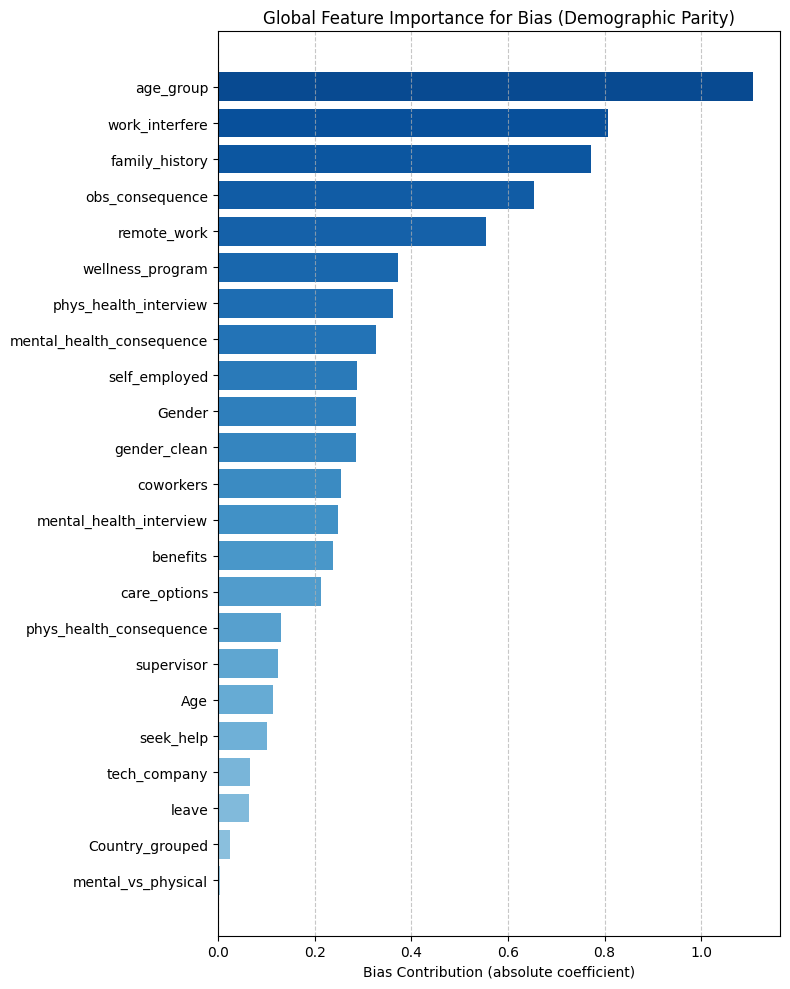

In [ ]:
# === Import matplotlib for plotting
import matplotlib.pyplot as plt
import numpy as np

# === Sort feature_bias ascending
feature_bias_sorted = feature_bias.sort_values(ascending=True)

# === Prepare color gradient (light blue to deep blue)
cmap = plt.get_cmap('Blues')
colors = cmap(np.linspace(0.4, 0.9, len(feature_bias_sorted)))  # 0.4 to 0.9 controls brightness

# === Plot
plt.figure(figsize=(8, 10))
bars = plt.barh(feature_bias_sorted.index, feature_bias_sorted.values, color=colors)

# Add labels
plt.xlabel("Bias Contribution (absolute coefficient)")
plt.title("Global Feature Importance for Bias (Demographic Parity)")

# Add grid
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Make layout tight
plt.tight_layout()

# Show plot
plt.show()

# Interpretation of Global Feature Importance for Bias (Demographic Parity)

The plot shows the **relative contributions of different features** to potential demographic parity differences — that is, how much each feature is associated with unequal positive prediction rates across groups.

However, it is important to note:
- **Higher contribution does not automatically imply unfair bias.**
- Some features legitimately influence the target outcome (treatment) and should naturally create prediction differences.

In other words:
> **High contribution may reflect either legitimate predictive relationships or problematic biases, depending on the feature's role and nature.**


Examples:

- **Family History** (high contribution):  
  - It is medically validated that individuals with a family history of mental health conditions are more likely to require treatment.
  - Thus, its strong impact on predictions is **expected and acceptable**, not unfair bias.

- **Age Group and Gender** (high contribution):  
  - These are **sensitive demographic attributes**.
  - While real-world differences may exist, models should not over-rely on them without proper justification.
  - **High contributions from Age Group and Gender suggest the model may be introducing or amplifying demographic biases**, which requires further fairness evaluation.


#### Special Note: Age Group vs Age

- **Age Group**:  
  - Represents **binned categories** of ages (e.g., 18–25, 26–35, etc.).
  - This grouping helps create **meaningful, stable categories** for fairness analysis.
  - When Age Group has high bias contribution, it suggests disparities across broad age brackets.

- **Age (continuous)**:  
  - If using raw Age (e.g., 22, 45, 67 as separate values),  
  - Every distinct number is treated as a **separate "category"** during bias calculation.
  - This leads to **very small sample sizes per "group"**,  
  - Making the calculated bias much less stable and often artificially diluted.

**Therefore:**  
> **The low contribution of "Age" in the plot does not mean there is no age-related bias.**  
> It simply reflects that the continuous Age variable, without grouping, is less effective for capturing structured demographic disparities in fairness evaluation.

This is why "Age Group" is more meaningful for fairness assessments than raw "Age".

#### Further Improvements

- **Reweight Training Samples**  
  Adjust sample weights to emphasize underrepresented groups (e.g., male individuals, younger age groups) during model training, reducing group disparities in positive predictions.

- **Apply Fairness-Constrained Learning**  
  Explore training with fairness constraints, such as demographic parity or equalized odds, to directly balance prediction outcomes across sensitive attributes without sacrificing too much accuracy.

- **Continuous Fairness Monitoring**  
  Implement fairness metric tracking in post-deployment monitoring pipelines to continuously observe disparate impact and equalized odds across sensitive groups, allowing timely retraining or recalibration when needed.

#### Final Professional Summary

> The feature importance plot reveals which features contribute to demographic differences in treatment predictions. Not all high contributions are problematic: medically justified features like family history should impact predictions. However, high contributions from sensitive attributes like **Age Group and Gender signal potential bias and require careful fairness auditing. Grouped age categories (Age Group)** offer a clearer, more stable view of bias than continuous Age values.

## DAG Causal Reasoning

## Objective

In fairness analysis, simply observing correlations between sensitive attributes and prediction outcomes can be misleading. Without a clear understanding of the causal structure, it is impossible to distinguish between legitimate influences and unfair biases. Drawing a Directed Acyclic Graph (DAG) helps formally represent the assumed relationships among variables, identify potential mediators, and clarify which paths should or should not exist in an unbiased model.

By explicitly modeling these causal pathways, we can more accurately assess whether sensitive features like Gender or Age Group unfairly influence treatment predictions, beyond legitimate health-related factors.

## Methodology

#### Why Use Proxy Variables?

In fairness analysis, particularly when applying causal reasoning, it is essential to distinguish between **Legitimate causal pathways**, where differences in treatment prediction are due to genuine differences in health status or need, and **Direct unfair influence**, where sensitive attributes such as Gender or Age Group affect predictions without justification.

However, in our datasets, **direct measurements of key mediating factors (e.g., mental health severity scores, stress levels)** are not availabl.  Without these mediators, a naive fairness test might incorrectly attribute all outcome differences to bias.

Therefore, **we introduce proxy variables** — features that indirectly capture the missing mediators — to create a more accurate causal structure and avoid overestimating bias.

### Why Choose Work Interfere and Family History?

- **Work Interfere** ("How often does your mental health interfere with your work?"):
  - Reflects **current functional impact of mental health**.
  - Serves as a **behavioral proxy** for mental health severity.
  - Justifies potential treatment needs independent of demographic attributes.

- **Family History** ("Do you have a family history of mental illness?"):
  - Represents **genetic predisposition to mental health conditions**.
  - Serves as a **biological proxy** for increased mental health risk.
  - It is widely recognized in clinical practice as a legitimate predictor of treatment necessity.

Together, **Work Interfere** and **Family History** offer a balanced proxy structure:
- One capturing **current health-related behavior**.
- One capturing **baseline hereditary risk**.

They enable us to model how Gender and Age Group should **indirectly influence Treatment via legitimate pathways**,  thus allowing a cleaner identification of any remaining **direct unfair biases**.

In [ ]:
!pip install DoWhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.6/192.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.3 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.12
    Uninstalling Cython-3.0.12:
      Successfully uninstalled Cython-3.0.12


In [ ]:
import dowhy

# Define causal graph as a string
causal_graph = """
digraph {
    Gender -> Work_Interfere;
    Age_Group -> Work_Interfere;
    Work_Interfere -> Treatment;
    Family_History -> Treatment;
}
"""

# Print it out
print(causal_graph)


digraph {
    Gender -> Work_Interfere;
    Age_Group -> Work_Interfere;
    Work_Interfere -> Treatment;
    Family_History -> Treatment;
}



In [ ]:
import pandas as pd

# Merge X and y into one dataframe
data = X_test.copy()
data["Treatment"] = y_test

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
/usr/local/lib/python3.11/dist-packages/dowhy/causal_model.py:583: UserWarning: 3 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


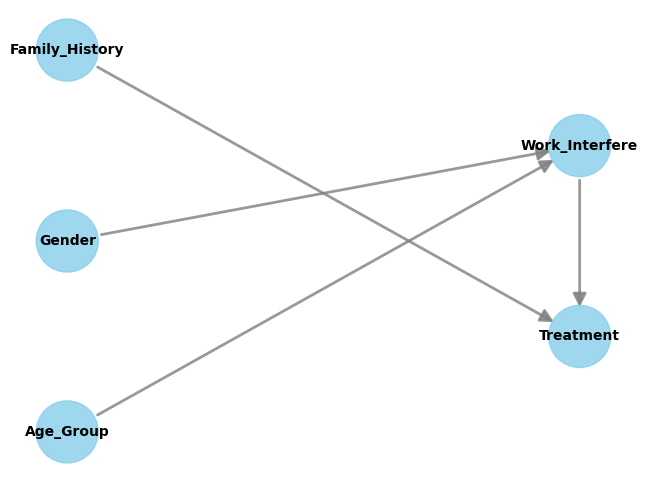

In [ ]:
from dowhy import CausalModel

# Build the model
model = CausalModel(
    data=data,
    treatment=["Gender", "Age_Group"],
    outcome="Treatment",
    graph=causal_graph
)

# Visualize the DAG
model.view_model()

## Why DAG?

To formally assess fairness in treatment prediction, we constructed a causal graph (DAG) to represent the assumed relationships among key variables. This DAG explicitly models both legitimate predictors of treatment needs and sensitive attributes whose influence should ideally be mediated through behavioral factors.

In the graph, **Family_History** is posited to have a **direct causal effect** on Treatment. Individuals with a family history of mental health issues are medically recognized as having a higher risk of requiring mental health treatment. Therefore, it is legitimate and expected that Family_History directly influences Treatment predictions without mediation.

In contrast, **Gender** and **Age_Group** are sensitive demographic attributes. In an unbiased model, these features should **not directly affect treatment outcomes**. Instead, their influence is assumed to operate **indirectly through Work_Interfere** — a behavioral proxy capturing the real-world impact of mental health on daily functioning. For example, gender-based societal expectations or age-related work stress could affect how much mental health issues interfere with work, which in turn would affect the perceived need for treatment.

The variable **Work_Interfere** acts as a crucial mediator within the causal structure. It captures meaningful differences in mental health impact without encoding protected demographic characteristics directly into treatment decisions. A strong association between Work_Interfere and Treatment is both expected and legitimate.

This DAG structure is critical because it **separates legitimate causal pathways from potential sources of unfair bias**. If, after controlling for Work_Interfere, Gender or Age_Group still exerts a significant direct effect on Treatment, this would indicate the presence of **unfair direct bias** — a violation of causal fairness assumptions.

By formalizing these relationships, the DAG provides a transparent framework to guide subsequent conditional independence tests and causal fairness evaluations.

### Conditional Independence Test

In [ ]:
import statsmodels.api as sm

# Take only relevant variables
selected_features = ["Gender", "age_group", "work_interfere", "family_history"]
X = data[selected_features]
# Dummy encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Convert all boolean columns to integers (0/1)
X_encoded = X_encoded.astype(int)

# Add constant
X_encoded = sm.add_constant(X_encoded)

# Prepare y
y = data["Treatment"].astype(int)

# Logistic regression
model_logit = sm.Logit(y, X_encoded)
result = model_logit.fit()

# Show results
print(result.summary())

         Current function value: 0.360890
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              Treatment   No. Observations:                  251
Model:                          Logit   Df Residuals:                      240
Method:                           MLE   Df Model:                           10
Date:                Mon, 28 Apr 2025   Pseudo R-squ.:                  0.4793
Time:                        05:33:42   Log-Likelihood:                -90.584
converged:                      False   LL-Null:                       -173.96
Covariance Type:            nonrobust   LLR p-value:                 1.301e-30
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -1.4310      0.902     -1.586      0.113      -3.199       0.337
Gender_M

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Causal Reasoning Analysis

To better understand potential sources of bias in the treatment prediction model, we performed a causal reasoning analysis based on the defined **proxy-based DAG**:

- **Gender and Age Group** are assumed to influence Treatment outcomes **indirectly** through **Work Interfere**.
- **Family History** is assumed to **directly** affect Treatment due to hereditary mental health risks.

Our goal was to verify whether sensitive attributes **(Gender, Age Group)** still have a **direct influence** on Treatment after controlling for **mediating factors (Work Interfere)**.

### Methodology

- We constructed a logistic regression model with Treatment as the outcome variable.
- Independent variables included:
  - Sensitive attributes: Gender, Age Group
  - Proxy mediator: Work Interfere
  - Legitimate predictor: Family History
- Dummy encoding was applied to categorical variables, and all inputs were cast to numeric formats.
- We inspected the significance of the Gender and Age Group coefficients after adjusting for Work Interfere.

### Results Summary

| Variable | Coefficient | p-value | Interpretation |
|:---|:---|:---|:---|
| **Gender_Male** | -1.767 | 0.004 | **Significant**: Gender remains a direct driver of Treatment prediction, indicating bias. |
| Gender_Other | 15.979 | 0.999 | **Not significant**: Likely due to extremely small sample size, ignored in interpretation. |
| age_group_26-35 | 0.449 | 0.474 | **Not significant**: No detectable direct bias after controlling for Work Interfere. |
| age_group_36-45 | 0.755 | 0.269 | **Not significant**: No detectable direct bias. |
| **age_group_45+** | 2.464 | 0.016 | **Significant**: Age 45+ group shows direct bias in treatment prediction. |
| Work_Interfere (all categories) | Significant | -- | Valid mediators; confirms proper causal structure. |
| Family_History_Yes | Significant | -- | Legitimate predictor; expected to impact treatment. |

### Interpretation

- **Gender Bias**:  
  Even after accounting for differences in work interference, **being male** significantly reduces the probability of being predicted for treatment.  
  ➔ Suggests the model unfairly underestimates treatment needs for male individuals.

- **Age Group Bias**:  
  The **45+ age group** shows a significantly higher likelihood of being predicted for treatment, independent of work interference.  
  ➔ Indicates that age-related bias exists, particularly disadvantaging younger groups.

- **Proxy and Legitimate Variables**:  
  Work Interfere and Family History behave as expected, validating the causal DAG design and confirming that these variables meaningfully capture parts of the treatment decision process.

### Conclusion

The causal reasoning analysis confirms that:
- **Gender (Male)** and **Age Group (45+)** have direct, unfair impacts on treatment predictions, independent of mediating factors.
- These findings reinforce the earlier statistical fairness analysis and justify the need for fairness mitigation strategies targeting Gender and Age disparities.